In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

In [2]:
data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()

X = data.drop('Class', axis=1)
y = data.Class

X_train_v, X_test, y_train_v, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_v, y_train_v, 
                                                            test_size=0.2, random_state=42)

X_train = scalar.fit_transform(X_train)
X_validate = scalar.transform(X_validate)
X_test = scalar.transform(X_test)

w_p = y_train.value_counts()[0] / len(y_train)
w_n = y_train.value_counts()[1] / len(y_train)

print(f"Fraudulant transaction weight: {w_n}")
print(f"Non-Fraudulant transaction weight: {w_p}")

Fraudulant transaction weight: 0.0017994745785028623
Non-Fraudulant transaction weight: 0.9982005254214972


In [17]:
print(f"TRAINING: X_train: {X_train.shape}, y_train: {y_train.shape}\n{'_'*55}")
print(f"VALIDATION: X_validate: {X_validate.shape}, y_validate: {y_validate.shape}\n{'_'*50}")
print(f"TESTING: X_test: {X_test.shape}, y_test: {y_test.shape}")

TRAINING: X_train: (159491, 30), y_train: (159491,)
_______________________________________________________
VALIDATION: X_validate: (39873, 30), y_validate: (39873,)
__________________________________________________
TESTING: X_test: (85443, 30), y_test: (85443,)


In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

def print_score(label, prediction, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, prediction)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n") 

In [19]:
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[-1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [20]:
METRICS = [
#     keras.metrics.Accuracy(name='accuracy'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=METRICS)

callbacks = [keras.callbacks.ModelCheckpoint('fraud_model_at_epoch_{epoch}.h5')]
class_weight = {0:w_p, 1:w_n}

r = model.fit(
    X_train, y_train, 
    validation_data=(X_validate, y_validate),
    batch_size=2048, 
    epochs=300, 
#     class_weight=class_weight,
    callbacks=callbacks,
)

Epoch 1/300
78/78 [==============================] - 4s 31ms/step - loss: 0.8053 - fn: 100.0000 - fp: 74354.0000 - tn: 84850.0000 - tp: 187.0000 - precision: 0.0025 - recall: 0.6516 - val_loss: 0.6780 - val_fn: 7.0000 - val_fp: 12868.0000 - val_tn: 26936.0000 - val_tp: 62.0000 - val_precision: 0.0048 - val_recall: 0.8986
Epoch 2/300
78/78 [==============================] - 2s 28ms/step - loss: 0.6860 - fn: 47.0000 - fp: 61059.0000 - tn: 98145.0000 - tp: 240.0000 - precision: 0.0039 - recall: 0.8362 - val_loss: 0.6157 - val_fn: 10.0000 - val_fp: 4517.0000 - val_tn: 35287.0000 - val_tp: 59.0000 - val_precision: 0.0129 - val_recall: 0.8551
Epoch 3/300
78/78 [==============================] - 2s 29ms/step - loss: 0.6103 - fn: 46.0000 - fp: 47954.0000 - tn: 111250.0000 - tp: 241.0000 - precision: 0.0050 - recall: 0.8397 - val_loss: 0.5729 - val_fn: 9.0000 - val_fp: 2089.0000 - val_tn: 37715.0000 - val_tp: 60.0000 - val_precision: 0.0279 - val_recall: 0.8696
Epoch 4/300
78/78 [==============

Epoch 27/300
78/78 [==============================] - 2s 28ms/step - loss: 0.0271 - fn: 86.0000 - fp: 93.0000 - tn: 159111.0000 - tp: 201.0000 - precision: 0.6837 - recall: 0.7003 - val_loss: 0.0277 - val_fn: 14.0000 - val_fp: 14.0000 - val_tn: 39790.0000 - val_tp: 55.0000 - val_precision: 0.7971 - val_recall: 0.7971
Epoch 28/300
78/78 [==============================] - 2s 29ms/step - loss: 0.0270 - fn: 93.0000 - fp: 92.0000 - tn: 159112.0000 - tp: 194.0000 - precision: 0.6783 - recall: 0.6760 - val_loss: 0.0242 - val_fn: 14.0000 - val_fp: 14.0000 - val_tn: 39790.0000 - val_tp: 55.0000 - val_precision: 0.7971 - val_recall: 0.7971
Epoch 29/300
78/78 [==============================] - 2s 29ms/step - loss: 0.0254 - fn: 94.0000 - fp: 88.0000 - tn: 159116.0000 - tp: 193.0000 - precision: 0.6868 - recall: 0.6725 - val_loss: 0.0264 - val_fn: 14.0000 - val_fp: 14.0000 - val_tn: 39790.0000 - val_tp: 55.0000 - val_precision: 0.7971 - val_recall: 0.7971
Epoch 30/300
78/78 [=======================

Epoch 53/300
78/78 [==============================] - 2s 30ms/step - loss: 0.0100 - fn: 87.0000 - fp: 48.0000 - tn: 159156.0000 - tp: 200.0000 - precision: 0.8065 - recall: 0.6969 - val_loss: 0.0105 - val_fn: 13.0000 - val_fp: 14.0000 - val_tn: 39790.0000 - val_tp: 56.0000 - val_precision: 0.8000 - val_recall: 0.8116
Epoch 54/300
78/78 [==============================] - 2s 29ms/step - loss: 0.0096 - fn: 89.0000 - fp: 45.0000 - tn: 159159.0000 - tp: 198.0000 - precision: 0.8148 - recall: 0.6899 - val_loss: 0.0088 - val_fn: 13.0000 - val_fp: 13.0000 - val_tn: 39791.0000 - val_tp: 56.0000 - val_precision: 0.8116 - val_recall: 0.8116
Epoch 55/300
78/78 [==============================] - 2s 28ms/step - loss: 0.0096 - fn: 92.0000 - fp: 50.0000 - tn: 159154.0000 - tp: 195.0000 - precision: 0.7959 - recall: 0.6794 - val_loss: 0.0099 - val_fn: 13.0000 - val_fp: 13.0000 - val_tn: 39791.0000 - val_tp: 56.0000 - val_precision: 0.8116 - val_recall: 0.8116
Epoch 56/300
78/78 [=======================

Epoch 79/300
78/78 [==============================] - 2s 29ms/step - loss: 0.0049 - fn: 85.0000 - fp: 24.0000 - tn: 159180.0000 - tp: 202.0000 - precision: 0.8938 - recall: 0.7038 - val_loss: 0.0055 - val_fn: 15.0000 - val_fp: 11.0000 - val_tn: 39793.0000 - val_tp: 54.0000 - val_precision: 0.8308 - val_recall: 0.7826
Epoch 80/300
78/78 [==============================] - 2s 27ms/step - loss: 0.0046 - fn: 79.0000 - fp: 28.0000 - tn: 159176.0000 - tp: 208.0000 - precision: 0.8814 - recall: 0.7247 - val_loss: 0.0052 - val_fn: 16.0000 - val_fp: 9.0000 - val_tn: 39795.0000 - val_tp: 53.0000 - val_precision: 0.8548 - val_recall: 0.7681
Epoch 81/300
78/78 [==============================] - 2s 27ms/step - loss: 0.0048 - fn: 86.0000 - fp: 34.0000 - tn: 159170.0000 - tp: 201.0000 - precision: 0.8553 - recall: 0.7003 - val_loss: 0.0052 - val_fn: 16.0000 - val_fp: 8.0000 - val_tn: 39796.0000 - val_tp: 53.0000 - val_precision: 0.8689 - val_recall: 0.7681
Epoch 82/300
78/78 [=========================

Epoch 105/300
78/78 [==============================] - 2s 32ms/step - loss: 0.0031 - fn: 72.0000 - fp: 21.0000 - tn: 159183.0000 - tp: 215.0000 - precision: 0.9110 - recall: 0.7491 - val_loss: 0.0045 - val_fn: 16.0000 - val_fp: 7.0000 - val_tn: 39797.0000 - val_tp: 53.0000 - val_precision: 0.8833 - val_recall: 0.7681
Epoch 106/300
78/78 [==============================] - 3s 32ms/step - loss: 0.0034 - fn: 80.0000 - fp: 30.0000 - tn: 159174.0000 - tp: 207.0000 - precision: 0.8734 - recall: 0.7213 - val_loss: 0.0045 - val_fn: 19.0000 - val_fp: 5.0000 - val_tn: 39799.0000 - val_tp: 50.0000 - val_precision: 0.9091 - val_recall: 0.7246
Epoch 107/300
78/78 [==============================] - 2s 30ms/step - loss: 0.0033 - fn: 76.0000 - fp: 21.0000 - tn: 159183.0000 - tp: 211.0000 - precision: 0.9095 - recall: 0.7352 - val_loss: 0.0046 - val_fn: 16.0000 - val_fp: 8.0000 - val_tn: 39796.0000 - val_tp: 53.0000 - val_precision: 0.8689 - val_recall: 0.7681
Epoch 108/300
78/78 [======================

Epoch 131/300
78/78 [==============================] - 2s 29ms/step - loss: 0.0024 - fn: 61.0000 - fp: 15.0000 - tn: 159189.0000 - tp: 226.0000 - precision: 0.9378 - recall: 0.7875 - val_loss: 0.0046 - val_fn: 16.0000 - val_fp: 7.0000 - val_tn: 39797.0000 - val_tp: 53.0000 - val_precision: 0.8833 - val_recall: 0.7681
Epoch 132/300
78/78 [==============================] - 2s 30ms/step - loss: 0.0025 - fn: 59.0000 - fp: 15.0000 - tn: 159189.0000 - tp: 228.0000 - precision: 0.9383 - recall: 0.7944 - val_loss: 0.0047 - val_fn: 16.0000 - val_fp: 7.0000 - val_tn: 39797.0000 - val_tp: 53.0000 - val_precision: 0.8833 - val_recall: 0.7681
Epoch 133/300
78/78 [==============================] - 2s 29ms/step - loss: 0.0024 - fn: 59.0000 - fp: 17.0000 - tn: 159187.0000 - tp: 228.0000 - precision: 0.9306 - recall: 0.7944 - val_loss: 0.0045 - val_fn: 17.0000 - val_fp: 5.0000 - val_tn: 39799.0000 - val_tp: 52.0000 - val_precision: 0.9123 - val_recall: 0.7536
Epoch 134/300
78/78 [======================

Epoch 157/300
78/78 [==============================] - 2s 29ms/step - loss: 0.0021 - fn: 57.0000 - fp: 21.0000 - tn: 159183.0000 - tp: 230.0000 - precision: 0.9163 - recall: 0.8014 - val_loss: 0.0046 - val_fn: 16.0000 - val_fp: 7.0000 - val_tn: 39797.0000 - val_tp: 53.0000 - val_precision: 0.8833 - val_recall: 0.7681
Epoch 158/300
78/78 [==============================] - 2s 29ms/step - loss: 0.0020 - fn: 59.0000 - fp: 17.0000 - tn: 159187.0000 - tp: 228.0000 - precision: 0.9306 - recall: 0.7944 - val_loss: 0.0051 - val_fn: 16.0000 - val_fp: 7.0000 - val_tn: 39797.0000 - val_tp: 53.0000 - val_precision: 0.8833 - val_recall: 0.7681
Epoch 159/300
78/78 [==============================] - 2s 30ms/step - loss: 0.0021 - fn: 55.0000 - fp: 17.0000 - tn: 159187.0000 - tp: 232.0000 - precision: 0.9317 - recall: 0.8084 - val_loss: 0.0049 - val_fn: 16.0000 - val_fp: 6.0000 - val_tn: 39798.0000 - val_tp: 53.0000 - val_precision: 0.8983 - val_recall: 0.7681
Epoch 160/300
78/78 [======================

Epoch 183/300
78/78 [==============================] - 2s 29ms/step - loss: 0.0019 - fn: 52.0000 - fp: 13.0000 - tn: 159191.0000 - tp: 235.0000 - precision: 0.9476 - recall: 0.8188 - val_loss: 0.0050 - val_fn: 13.0000 - val_fp: 8.0000 - val_tn: 39796.0000 - val_tp: 56.0000 - val_precision: 0.8750 - val_recall: 0.8116
Epoch 184/300
78/78 [==============================] - 2s 29ms/step - loss: 0.0017 - fn: 53.0000 - fp: 14.0000 - tn: 159190.0000 - tp: 234.0000 - precision: 0.9435 - recall: 0.8153 - val_loss: 0.0051 - val_fn: 13.0000 - val_fp: 8.0000 - val_tn: 39796.0000 - val_tp: 56.0000 - val_precision: 0.8750 - val_recall: 0.8116
Epoch 185/300
78/78 [==============================] - 2s 30ms/step - loss: 0.0017 - fn: 48.0000 - fp: 9.0000 - tn: 159195.0000 - tp: 239.0000 - precision: 0.9637 - recall: 0.8328 - val_loss: 0.0050 - val_fn: 13.0000 - val_fp: 8.0000 - val_tn: 39796.0000 - val_tp: 56.0000 - val_precision: 0.8750 - val_recall: 0.8116
Epoch 186/300
78/78 [=======================

Epoch 209/300
78/78 [==============================] - 2s 29ms/step - loss: 0.0015 - fn: 39.0000 - fp: 12.0000 - tn: 159192.0000 - tp: 248.0000 - precision: 0.9538 - recall: 0.8641 - val_loss: 0.0052 - val_fn: 14.0000 - val_fp: 6.0000 - val_tn: 39798.0000 - val_tp: 55.0000 - val_precision: 0.9016 - val_recall: 0.7971
Epoch 210/300
78/78 [==============================] - 2s 28ms/step - loss: 0.0014 - fn: 44.0000 - fp: 12.0000 - tn: 159192.0000 - tp: 243.0000 - precision: 0.9529 - recall: 0.8467 - val_loss: 0.0051 - val_fn: 14.0000 - val_fp: 6.0000 - val_tn: 39798.0000 - val_tp: 55.0000 - val_precision: 0.9016 - val_recall: 0.7971
Epoch 211/300
78/78 [==============================] - 2s 29ms/step - loss: 0.0013 - fn: 42.0000 - fp: 9.0000 - tn: 159195.0000 - tp: 245.0000 - precision: 0.9646 - recall: 0.8537 - val_loss: 0.0052 - val_fn: 14.0000 - val_fp: 6.0000 - val_tn: 39798.0000 - val_tp: 55.0000 - val_precision: 0.9016 - val_recall: 0.7971
Epoch 212/300
78/78 [=======================

Epoch 235/300
78/78 [==============================] - 2s 29ms/step - loss: 0.0014 - fn: 50.0000 - fp: 15.0000 - tn: 159189.0000 - tp: 237.0000 - precision: 0.9405 - recall: 0.8258 - val_loss: 0.0057 - val_fn: 14.0000 - val_fp: 9.0000 - val_tn: 39795.0000 - val_tp: 55.0000 - val_precision: 0.8594 - val_recall: 0.7971
Epoch 236/300
78/78 [==============================] - 2s 30ms/step - loss: 0.0013 - fn: 35.0000 - fp: 14.0000 - tn: 159190.0000 - tp: 252.0000 - precision: 0.9474 - recall: 0.8780 - val_loss: 0.0055 - val_fn: 14.0000 - val_fp: 6.0000 - val_tn: 39798.0000 - val_tp: 55.0000 - val_precision: 0.9016 - val_recall: 0.7971
Epoch 237/300
78/78 [==============================] - 2s 29ms/step - loss: 0.0013 - fn: 40.0000 - fp: 15.0000 - tn: 159189.0000 - tp: 247.0000 - precision: 0.9427 - recall: 0.8606 - val_loss: 0.0055 - val_fn: 14.0000 - val_fp: 7.0000 - val_tn: 39797.0000 - val_tp: 55.0000 - val_precision: 0.8871 - val_recall: 0.7971
Epoch 238/300
78/78 [======================

Epoch 261/300
78/78 [==============================] - 2s 29ms/step - loss: 9.3511e-04 - fn: 35.0000 - fp: 13.0000 - tn: 159191.0000 - tp: 252.0000 - precision: 0.9509 - recall: 0.8780 - val_loss: 0.0057 - val_fn: 15.0000 - val_fp: 4.0000 - val_tn: 39800.0000 - val_tp: 54.0000 - val_precision: 0.9310 - val_recall: 0.7826
Epoch 262/300
78/78 [==============================] - 2s 29ms/step - loss: 0.0011 - fn: 32.0000 - fp: 8.0000 - tn: 159196.0000 - tp: 255.0000 - precision: 0.9696 - recall: 0.8885 - val_loss: 0.0058 - val_fn: 14.0000 - val_fp: 6.0000 - val_tn: 39798.0000 - val_tp: 55.0000 - val_precision: 0.9016 - val_recall: 0.7971
Epoch 263/300
78/78 [==============================] - 2s 29ms/step - loss: 0.0010 - fn: 39.0000 - fp: 10.0000 - tn: 159194.0000 - tp: 248.0000 - precision: 0.9612 - recall: 0.8641 - val_loss: 0.0058 - val_fn: 14.0000 - val_fp: 6.0000 - val_tn: 39798.0000 - val_tp: 55.0000 - val_precision: 0.9016 - val_recall: 0.7971
Epoch 264/300
78/78 [===================

In [21]:
score = model.evaluate(X_test, y_test)
print(score)

2671/2671 [==============================] - 3s 993us/step - loss: 0.0034 - fn: 26.0000 - fp: 9.0000 - tn: 85298.0000 - tp: 110.0000 - precision: 0.9244 - recall: 0.8088
[0.003438896732404828, 26.0, 9.0, 85298.0, 110.0, 0.924369752407074, 0.8088235259056091]


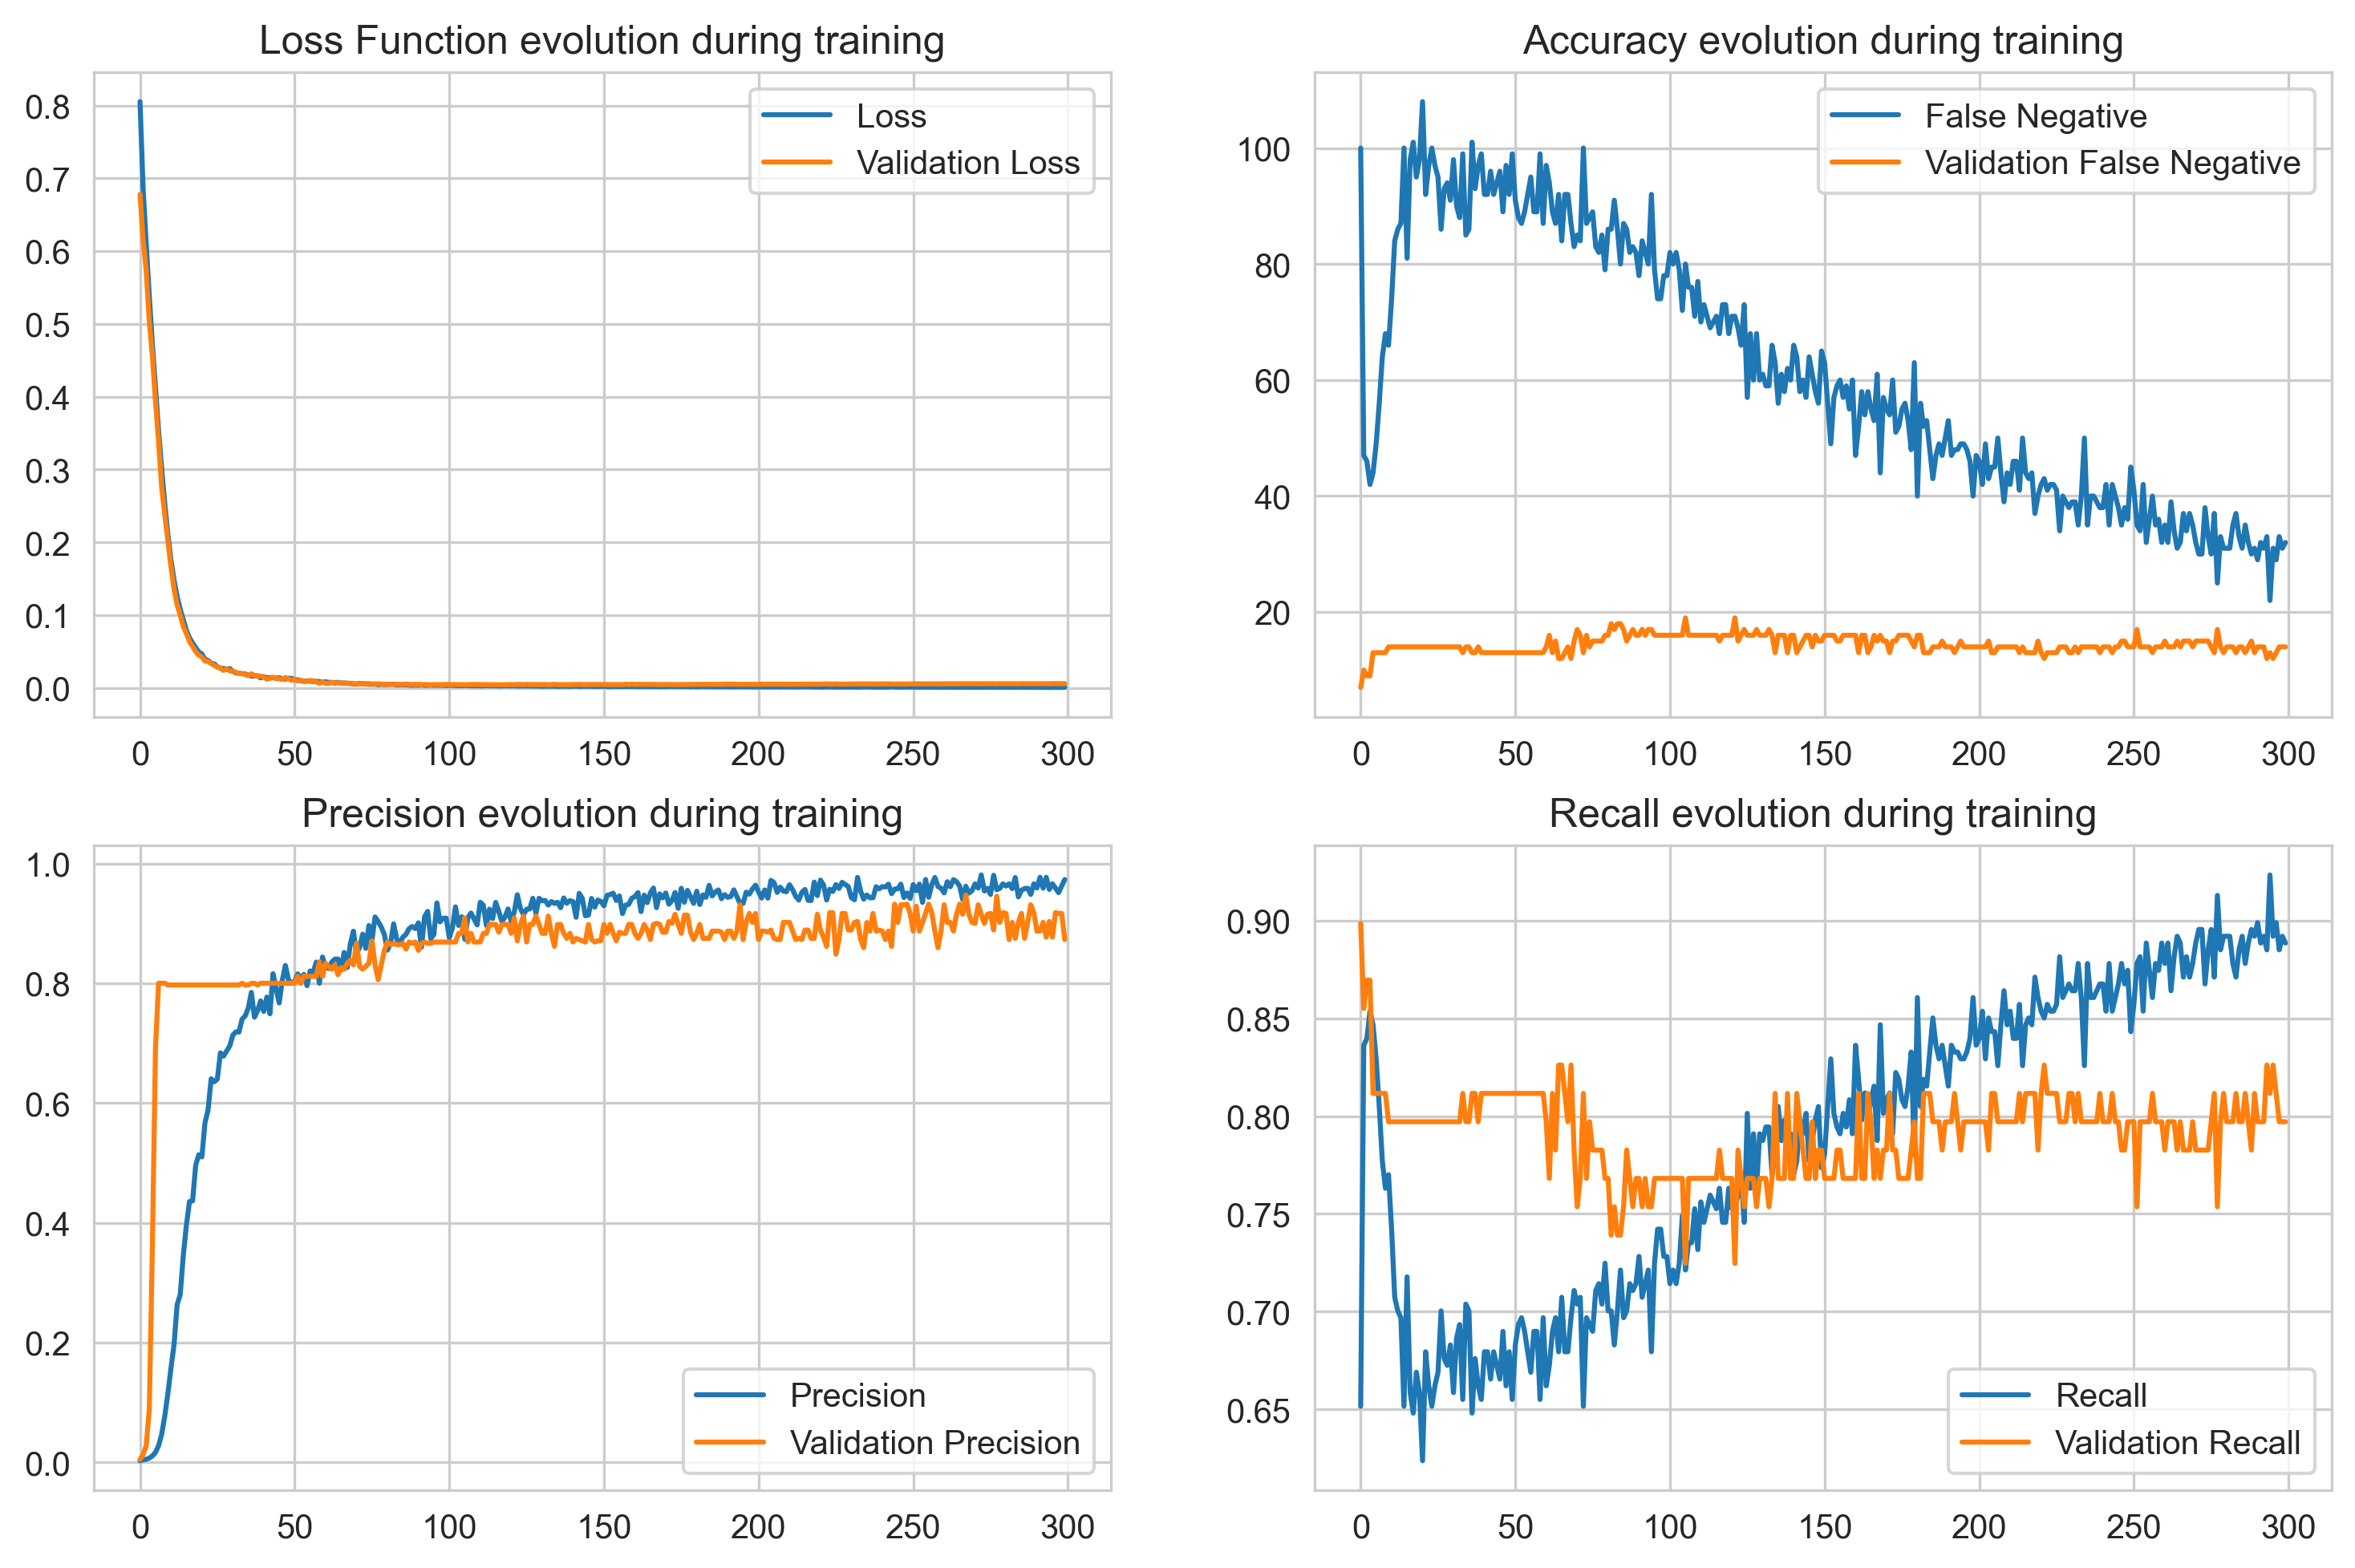

In [29]:
plt.figure(figsize=(12, 16),dpi=300)

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.title('Loss Function evolution during training')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['fn'], label='False Negative')
plt.plot(r.history['val_fn'], label='Validation False Negative')
plt.title('Accuracy evolution during training')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='Precision')
plt.plot(r.history['val_precision'], label='Validation Precision')
plt.title('Precision evolution during training')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='Recall')
plt.plot(r.history['val_recall'], label='Validation Recall')
plt.title('Recall evolution during training')
plt.legend()

In [22]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print_score(y_train, y_train_pred.round(), train=True)
print_score(y_test, y_test_pred.round(), train=False)

scores_dict = {
    'ANNs': {
        'Train': f1_score(y_train, y_train_pred.round()),
        'Test': f1_score(y_test, y_test_pred.round()),
    },
}

Train Result:
Accuracy Score: 99.99%
_______________________________________________
Classification Report:
                  0      1  accuracy  macro avg  weighted avg
precision      1.00   1.00      1.00       1.00          1.00
recall         1.00   0.95      1.00       0.98          1.00
f1-score       1.00   0.97      1.00       0.99          1.00
support   159204.00 287.00      1.00  159491.00     159491.00
_______________________________________________
Confusion Matrix: 
 [[159204      0]
 [    14    273]]

Test Result:
Accuracy Score: 99.96%
_______________________________________________
Classification Report:
                 0      1  accuracy  macro avg  weighted avg
precision     1.00   0.92      1.00       0.96          1.00
recall        1.00   0.81      1.00       0.90          1.00
f1-score      1.00   0.86      1.00       0.93          1.00
support   85307.00 136.00      1.00   85443.00      85443.00
_______________________________________________
Confusion Matrix: 